In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
import datetime
import glob
import pickle
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification.f_beta import F1Score
import random
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
random.seed(42)

c:\Users\madhava\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


In [95]:
accuracy = MulticlassAccuracy(num_classes=31,top_k=1)
F1 = F1Score(task='multiclass',num_classes=31, average='macro')

In [2]:
paths=[r"E:\Dataset\terrain classification.v27i.folder/*",r"E:\Dataset\terrain classification1.v11i.folder",
       r"E:\Dataset\terrain classification2.v6i.folder",r"E:\Dataset\terrain classification3.v6i.folder",r"E:\Dataset\terrain classification4.v12i.folder"]
l=[]
for path in paths:
    for i in sorted(list(glob.glob(path+'/*'))):
        for j in sorted(list(glob.glob(i+'/*'))):
            if j.endswith('.jpg') or j.endswith('.JPG') or j.endswith('.png') or j.endswith('.PNG') or j.endswith('.jpeg') or j.endswith('.JPEG') or j.endswith('.tif') or j.endswith('.TIF'):
                l.append(j.split('\\')[-1])

with open('path.pkl', 'wb') as f:
    pickle.dump(l, f)

In [3]:
classes=[
    i.split('\\')[-1].lower() for i in glob.glob(r"gtos-mobile\FinalDataset\train"+'/*')
]

In [8]:
"""aluminium,(0.363-1.220)
asphalt,(0.016)
brick,(0.015)
cement,(0.012)
cloth, 10 to 50 µm
dry_leaf,5 µm to 100 µm 
glass,(0.010)
grass,50 µm to 200 µm.
gravel,(0.023)
large_limestone, 10 µm to 100 µm
leaf,10 µm to 100 µm
metal_cover,(0.022)
moss,100 µm to 500 µm 
paint_cover,5 µm to 20 µm
painting,10 µm to 30 µm
painting_turf, 2 µm to 5 µm
paper, 1 µm to 3 µm.
pebble,10 µm to 50 µm
plastic,(0.009)
plastic_cover,(0.009)
root, 10 µm to 50 µm
sand, 10 µm to 50 µm
sandPaper,10 µm to 50 µm
shale, 5 µm to 50 µm 
small_limestone,10 µm to 100 µm
soil,5 µm to 30 µm
steel,(0.012)
stone_asphalt,(0.016)
stone_brick,(0.015)
stone_cement,(0.012)
turf,20 µm to 100 µm
water,micrometers (µm) or microinches (µin)
wood_chips,(0.013)"""

"""roughness={

'aluminum': (0.0001-0.001),

'asphalt':(0.5-2.5),

'brick':(0.5-2.5),

'cement':(1.0-5.0),

'cloth':(0.001,0.005),

'dry leaf': (0.005,0.1),

'glass':(0.00001,0.0001),

'grass':(0.05,0.2),

'gravel':(1,10)

'large limestone': (0.01,0.1),

'leaf': (0.01-0.1),

'metal cover':(0.1,10),

'moss': (0.1,0.5),

'paint cover':(0.005,0.02),

'painting':(0.01,0.03),

'painting turf': (0.002,0.005),

'paper':(0.001,0.003), 

'pebble': (0.01,0.05),

"plastic':(0.0001,0.01), 

'plastic cover':(0.0001,0.1),

'root':(0.01,0.05),

'sand':(0.01,0.05),

'sandPaper: (0.01,0.05), 

'shale':(0.005,0.05),

small limestone': (0.01,0.1),

'soil':(0.005,0.03), 

'steel":(0.0001,0.01),

'stone asphalt':(0.5,0.25), 

'stone brick":(0.5,2.5),

'stone cement':(1.0,5.0)

"turf': (0.02,0.1),

"water':(0.1,0.2), 

"wood chips :(0.0001,0.01)

}"""

'roughness={\n\n\'aluminum\': (0.0001-0.001),\n\n\'asphalt\':(0.5-2.5),\n\n\'brick\':(0.5-2.5),\n\n\'cement\':(1.0-5.0),\n\n\'cloth\':(0.001,0.005),\n\n\'dry leaf\': (0.005,0.1),\n\n\'glass\':(0.00001,0.0001),\n\n\'grass\':(0.05,0.2),\n\n\'gravel\':(1,10)\n\n\'large limestone\': (0.01,0.1),\n\n\'leaf\': (0.01-0.1),\n\n\'metal cover\':(0.1,10),\n\n\'moss\': (0.1,0.5),\n\n\'paint cover\':(0.005,0.02),\n\n\'painting\':(0.01,0.03),\n\n\'painting turf\': (0.002,0.005),\n\n\'paper\':(0.001,0.003), \n\n\'pebble\': (0.01,0.05),\n\n"plastic\':(0.0001,0.01), \n\n\'plastic cover\':(0.0001,0.1),\n\n\'root\':(0.01,0.05),\n\n\'sand\':(0.01,0.05),\n\n\'sandPaper: (0.01,0.05), \n\n\'shale\':(0.005,0.05),\n\nsmall limestone\': (0.01,0.1),\n\n\'soil\':(0.005,0.03), \n\n\'steel":(0.0001,0.01),\n\n\'stone asphalt\':(0.5,0.25), \n\n\'stone brick":(0.5,2.5),\n\n\'stone cement\':(1.0,5.0)\n\n"turf\': (0.02,0.1),\n\n"water\':(0.1,0.2), \n\n"wood chips :(0.0001,0.01)\n\n}'

In [10]:
sliperiness={
    'aluminum':random.uniform(0,1),
    'asphalt':random.uniform(0,1),
    'brick':random.uniform(0,1),
    'cement':random.uniform(0,1),
    'cloth':random.uniform(0,1),
    'dry_leaf':random.uniform(0,1),
    'glass':random.uniform(0,1),
    'grass':random.uniform(0,1),
    'gravel':random.uniform(0,1),
    'large_limestone':random.uniform(0,1),
    'leaf':random.uniform(0,1),
    'metal_cover':random.uniform(0,1),
    'moss':random.uniform(0,1),
    'paint_cover':random.uniform(0,1),
    'painting':random.uniform(0,1),
    'painting_turf':random.uniform(0,1),
    'paper':random.uniform(0,1),
    'pebble':random.uniform(0,1),
    'plastic':random.uniform(0,1),
    'plastic_cover':random.uniform(0,1),
    'root':random.uniform(0,1),
    'sand':random.uniform(0,1),
    'sandPaper':random.uniform(0,1),
    'shale':random.uniform(0,1),
    'small_limestone':random.uniform(0,1),
    'soil':random.uniform(0,1),
    'steel':random.uniform(0,1),
    'stone_asphalt':random.uniform(0,1),
    'stone_brick':random.uniform(0,1),
    'stone_cement':random.uniform(0,1),
    'turf':random.uniform(0,1),
    'water':random.uniform(0,1),
    'wood_chips':random.uniform(0,1)
}
roughness={
    'aluminum':random.uniform(0,1),
    'asphalt':random.uniform(0,1),
    'brick':random.uniform(0,1),
    'cement':random.uniform(0,1),
    'cloth':random.uniform(0,1),
    'dry_leaf':random.uniform(0,1),
    'glass':random.uniform(0,1),
    'grass':random.uniform(0,1),
    'gravel':random.uniform(0,1),
    'large_limestone':random.uniform(0,1),
    'leaf':random.uniform(0,1),
    'metal_cover':random.uniform(0,1),
    'moss':random.uniform(0,1),
    'paint_cover':random.uniform(0,1),
    'painting':random.uniform(0,1),
    'painting_turf':random.uniform(0,1),
    'paper':random.uniform(0,1),
    'pebble':random.uniform(0,1),
    'plastic':random.uniform(0,1),
    'plastic_cover':random.uniform(0,1),
    'root':random.uniform(0,1),
    'sand':random.uniform(0,1),
    'sandPaper':random.uniform(0,1),
    'shale':random.uniform(0,1),
    'small_limestone':random.uniform(0,1),
    'soil':random.uniform(0,1),
    'steel':random.uniform(0,1),
    'stone_asphalt':random.uniform(0,1),
    'stone_brick':random.uniform(0,1),
    'stone_cement':random.uniform(0,1),
    'turf':random.uniform(0,1),
    'water':random.uniform(0,1),
    'wood_chips':random.uniform(0,1)
}

In [11]:
def make_path_for_df(parent_directory):
    eps=1e-1
    for path in sorted(glob.glob(parent_directory+'/*')):
        for images in sorted(glob.glob(path+'/*')):
            if images.endswith('.jpg') or images.endswith('.JPG') or images.endswith('.png') or images.endswith('.PNG') or images.endswith('.jpeg') or images.endswith('.JPEG') or images.endswith('.tif') or images.endswith('.TIF'):
                try:
                    """if type(roughness[path.split('\\')[-1].lower()]) is tuple:
                        range1_roughness=roughness[path.split('\\')[-1].lower()][0]
                        range2_roughness=roughness[path.split('\\')[-1].lower()][1]
                    else:
                        range1_roughness=roughness[path.split('\\')[-1].lower()]
                        range2_roughness=roughness[path.split('\\')[-1].lower()]
                    range1_sliperiness=sliperiness[path.split('\\')[-1].lower()][0]
                    range2_sliperiness=sliperiness[path.split('\\')[-1].lower()][1]
                    
                    print(range1_roughness,range2_roughness,range1_sliperiness,range2_sliperiness)"""
                    yield images.replace('\\','/'),roughness[path.split('\\')[-1].lower()]+(random.choice([1,-1])*random.uniform(0,eps)),sliperiness[path.split('\\')[-1].lower()]+(random.choice([1,-1])*random.uniform(0,eps)), path.split('\\')[-1].lower()
                except:
                    print(path.split('\\')[-1].lower() + ' not found in dictionary')

In [12]:
random.uniform(
    0,1e-1)

0.02290480719641044

In [13]:
json_dict={}

In [14]:
count=0
for i,j,k,l in make_path_for_df(r'gtos-mobile\FinalDataset\train'):
    json_dict[count]={'path':i,'roughness':j,'sliperiness':k,'class':l}
    count+=1

mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dic

In [15]:
import json
with open('train.json', 'w') as fp:
    json.dump(json_dict, fp)

In [16]:
json_dict={}
count=0
for i,j,k,l in make_path_for_df(r'gtos-mobile\FinalDataset\test'):
    json_dict[count]={'path':i,'roughness':j,'sliperiness':k,'class':l}
    count+=1

mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dictionary
mud not found in dic

In [17]:
len(json_dict)


6374

In [18]:
with open('test.json', 'w') as fp:
    json.dump(json_dict, fp)

In [4]:
df=pd.read_json('train.json').T
test_df=pd.read_json('test.json').T

In [5]:
df['roughness']=df['roughness'].astype(float)
df['sliperiness']=df['sliperiness'].astype(float)
test_df['roughness']=test_df['roughness'].astype(float)
test_df['sliperiness']=test_df['sliperiness'].astype(float)

In [6]:
class gtos_dataset(Dataset):
    def __init__(self,df,transform=None):
        self.df=df
        self.transform=transform
        self.total_classes=list(np.unique(self.df['class']))
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        df_temp=self.df.iloc[idx]
        image_path=df_temp['path']
        image=Image.open(image_path)
        image=image.convert('RGB')
        image=np.array(image)
        image=self.transform(image=image)['image']
        return{
        'image':image,
        'roughness':torch.tensor(df_temp['roughness'],dtype=torch.float),
        'sliperiness':torch.tensor(df_temp['sliperiness'],dtype=torch.float),
        'class':F.one_hot(torch.tensor(self.total_classes.index(df_temp['class']),dtype=torch.long),num_classes=len(self.total_classes)).float(),
        'class_name':df_temp['class']

        }

In [7]:
len(np.unique(df['class']))

31

In [33]:
def return_class_weights(df):
    target=df['class']
    value_weights=1/df['class'].value_counts().sort_index().values
    samples_weight = torch.from_numpy(value_weights)
    samples_weight = samples_weight.double()
    sampler = WeightedRandomSampler(samples_weight, replacement=True, num_samples=int(len(df)*1.5))
    return sampler

In [34]:
len(df)

95115

In [35]:
df2=df.groupby('class').apply(lambda x: x.sample(1)).reset_index(drop=True)

In [37]:
visualize_loader=DataLoader(gtos_dataset(df2,transform=A.Compose([
    A.Normalize(),
    A.pytorch.ToTensorV2()
])),batch_size=1,num_workers=0,sampler=return_class_weights(df2))

In [57]:
from sklearn.model_selection import train_test_split
train_df,val_df=train_test_split(df,test_size=0.2,random_state=42)

train_loader=DataLoader(gtos_dataset(train_df,transform=A.Compose([
    A.Normalize(),
    A.RandomCrop(128,128,p=0.15),
    A.PadIfNeeded(min_height=256,min_width=256,p=1.0),
    A.HorizontalFlip(p=0.25),
    A.VerticalFlip(p=0.25),
    A.RandomBrightnessContrast(p=0.1),
    A.pytorch.ToTensorV2()])),batch_size=8,shuffle=False,sampler=return_class_weights(train_df))

val_loader=DataLoader(gtos_dataset(val_df,transform=A.Compose([
    A.Normalize(),
    A.pytorch.ToTensorV2()
])),batch_size=8,shuffle=False,sampler=return_class_weights(val_df))

In [58]:
test_loader=DataLoader(gtos_dataset(test_df,transform=A.Compose([
    A.Normalize(),
    A.pytorch.ToTensorV2()
])),batch_size=8,sampler=return_class_weights(test_df))

In [59]:
len(test_loader),len(train_loader),len(val_loader)

(1196, 14268, 3567)

In [60]:
train_df

,path,roughness,sliperiness,class
48177,gtos-mobile/FinalDataset/train/moss/384_sample...,0.312304,-0.022878,moss
54256,gtos-mobile/FinalDataset/train/paper/256_sampl...,0.401191,0.148146,paper
29489,gtos-mobile/FinalDataset/train/cloth/512_sampl...,0.611323,0.795856,cloth
84244,gtos-mobile/FinalDataset/train/stone_asphalt/5...,1.062311,0.137496,stone_asphalt
24010,gtos-mobile/FinalDataset/train/cement/512_samp...,0.751282,0.147273,cement
...,...,...,...,...
6265,gtos-mobile/FinalDataset/train/asphalt/256_sam...,0.345505,0.062690,asphalt
54886,gtos-mobile/FinalDataset/train/paper/384_sampl...,0.284236,0.264541,paper
76820,gtos-mobile/FinalDataset/train/small_limestone...,0.820885,0.896650,small_limestone
860,gtos-mobile/FinalDataset/train/Painting/256_sa...,0.233267,0.747952,painting


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.6306) tensor(0.6538)


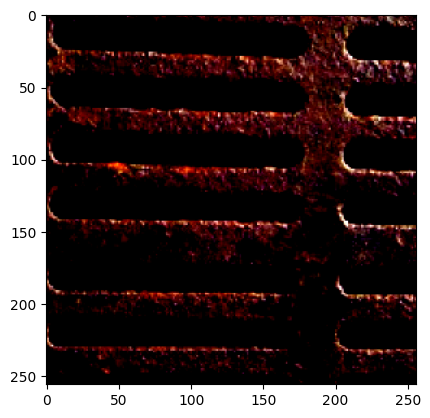

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.9042) tensor(0.3967)


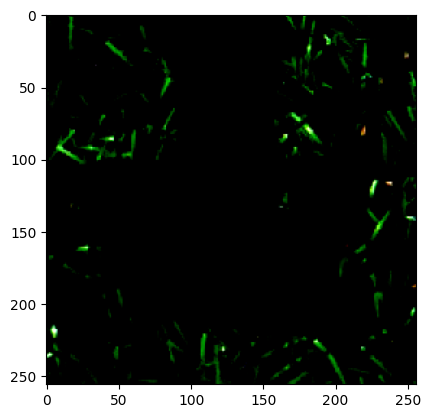

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.3539) tensor(0.3755)


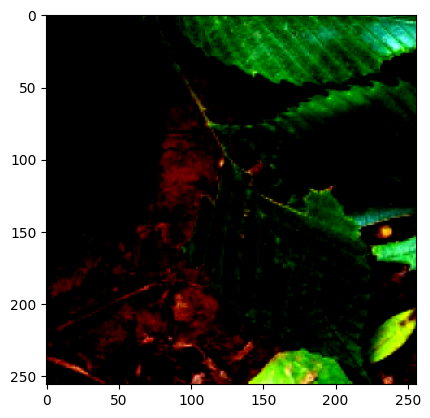

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.1876) tensor(0.1574)


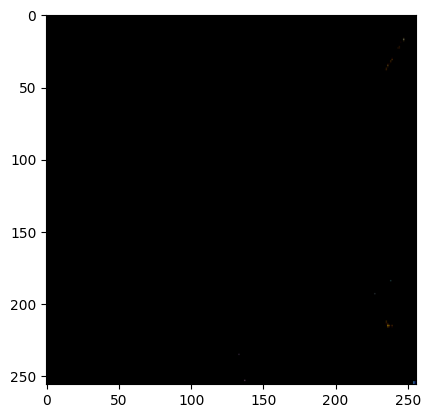

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.7150) tensor(0.4991)


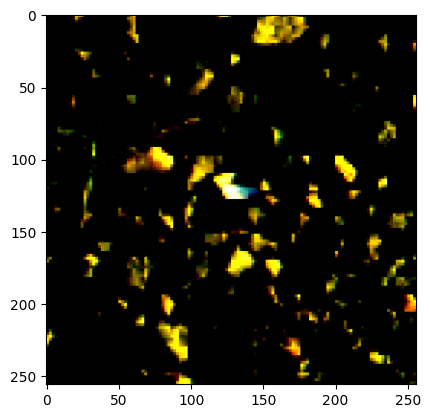

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.3652) tensor(0.1792)


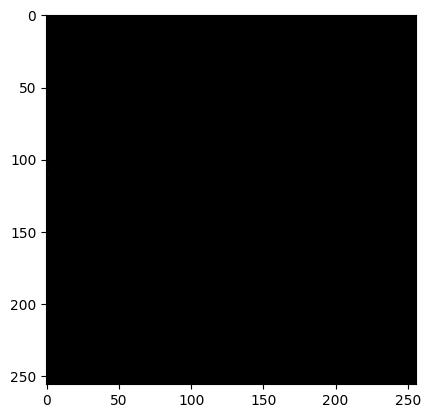

tensor(0.0114) tensor(0.0790)


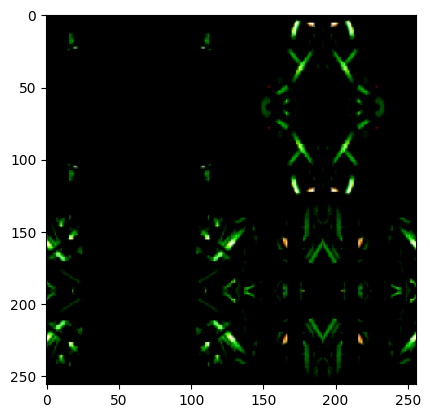

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0.7301) tensor(0.4945)


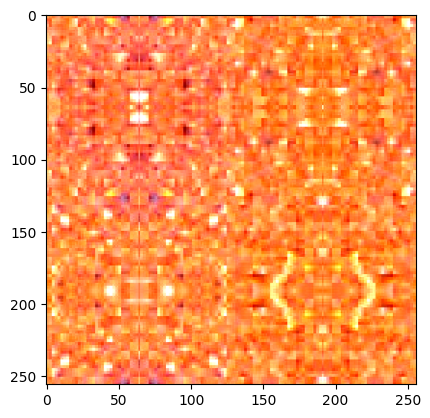

In [61]:
for i in train_loader:
    for j in i['image']:
        plt.imshow(j.permute(1,2,0))
        print(j.mean(),j.std())
        plt.show()
    break

In [86]:
from torchvision import models
extractor_model=models.mobilenet_v3_small(weights=models.MobileNet_V3_Small_Weights.IMAGENET1K_V1)
model.classifier[3]=nn.Identity()

In [87]:
class Mobilenet_reg(nn.Module):
    def __init__(self,mobilenet_model):
        super().__init__()
        self.mobilenet_model=mobilenet_model
        self.classifier=nn.Linear(1024,31)
        self.regression=nn.Sequential(
            nn.Linear(1024,512),
            nn.GELU(),
            nn.Linear(512,256),
            nn.GELU(),
            nn.Linear(256,2)
        )

    def forward(self,x):
        extraction=self.mobilenet_model(x)
        class_pred=self.classifier(extraction)
        regression_pred=self.regression(extraction)

        return class_pred,regression_pred


In [88]:
from sklearn.utils.class_weight import compute_class_weight
class_weights=compute_class_weight('balanced',classes=np.unique(df['class']),y=df['class'])
lossfn=nn.CrossEntropyLoss()

In [97]:
df.to_csv('train.csv',index=False)
test_df.to_csv('test.csv',index=False)

In [98]:
lossfn2=nn.MSELoss()

In [90]:
def train_one_iter(model,train_loader,optimizer,lossfn,lossfn2,device):
    model.train()
    train_loss=0
    train_acc=0
    train_f1=0
    train_mse=0
    for idx,i in tqdm(enumerate(train_loader),total=len(train_loader)):
        optimizer.zero_grad()
        image=i['image'].to(device)
        roughness=i['roughness'].to(device)
        sliperiness=i['sliperiness'].to(device)
        class_target=i['class'].to(device)
        class_pred,regression_pred=model(image)
        loss1=lossfn(class_pred,class_target.argmax(dim=1))
        loss2=lossfn2(regression_pred,torch.stack([roughness,sliperiness],dim=1))
        loss=loss1+loss2
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
        train_acc+=accuracy(class_pred,class_target.argmax(dim=1)).item()
        train_f1+=F1(class_pred,class_target.argmax(dim=1)).item()
        train_mse+=loss2.item()

        if idx%100==0:
            print(f'loss:{loss.item()}')
            print(f'accuracy:{accuracy(class_pred,class_target.argmax(dim=1)).item()}')
            print(f'f1:{F1(class_pred,class_target.argmax(dim=1)).item()}')
            print(f'mse:{loss2.item()}')
    return train_loss/len(train_loader),train_acc/len(train_loader),train_f1/len(train_loader),train_mse/len(train_loader)

In [91]:
def test_one_iter(model,test_loader,lossfn,lossfn2,device):
    model.eval()
    test_loss=0
    test_acc=0
    test_f1=0
    test_mse=0
    with torch.no_grad():
        for idx,i in tqdm(enumerate(test_loader),total=len(test_loader)):
            image=i['image'].to(device)
            roughness=i['roughness'].to(device)
            sliperiness=i['sliperiness'].to(device)
            class_target=i['class'].to(device)
            class_pred,regression_pred=model(image)
            loss1=lossfn(class_pred,class_target.argmax(dim=1))
            loss2=lossfn2(regression_pred,torch.stack([roughness,sliperiness],dim=1))
            loss=loss1+loss2
            test_loss+=loss.item()
            test_acc+=accuracy(class_pred,class_target.argmax(dim=1)).item()
            test_f1+=F1(class_pred,class_target.argmax(dim=1)).item()
            test_mse+=loss2.item()

            if idx%100==0:
                print(f'loss:{loss.item()}')
                print(f'accuracy:{accuracy(class_pred,class_target.argmax(dim=1)).item()}')
                print(f'f1:{F1(class_pred,class_target.argmax(dim=1)).item()}')
                print(f'mse:{loss2.item()}')
    return test_loss/len(test_loader),test_acc/len(test_loader),test_f1/len(test_loader),test_mse/len(test_loader)

In [92]:
def training_loop(model,optimizer,test_loader,train_loader,lossfn,lossfn2,device,epochs):
    history={
        'train_loss':[],
        'train_acc':[],
        'train_f1':[],
        'train_mse':[],
        'test_loss':[],
        'test_acc':[],
        'test_f1':[],
        'test_mse':[]
    }
    os.makedirs('classifier',exist_ok=True)
    writer=SummaryWriter('runs/terrain_classification')

    for epoch in range(epochs):

        train_loss,train_acc,train_f1,train_mse=train_one_iter(model,train_loader,optimizer,lossfn,lossfn2,device)
        test_loss,test_acc,test_f1,test_mse=test_one_iter(model,test_loader,lossfn,lossfn2,device)

        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['train_f1'].append(train_f1)
        history['train_mse'].append(train_mse)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        history['test_f1'].append(test_f1)
        history['test_mse'].append(test_mse)

        writer.add_scalar('train_loss',train_loss,epoch)
        writer.add_scalar('train_acc',train_acc,epoch)
        writer.add_scalar('train_f1',train_f1,epoch)
        writer.add_scalar('train_mse',train_mse,epoch)
        writer.add_scalar('test_loss',test_loss,epoch)
        writer.add_scalar('test_acc',test_acc,epoch)
        writer.add_scalar('test_f1',test_f1,epoch)
        writer.add_scalar('test_mse',test_mse,epoch)

        print(f'Epoch {epoch+1}/{epochs} train_loss:{train_loss} train_acc:{train_acc} train_f1:{train_f1} train_mse:{train_mse} test_loss:{test_loss} test_acc:{test_acc} test_f1:{test_f1} test_mse:{test_mse}')

        torch.save(model.state_dict(),f'classifier/epoch_{epoch+1}.pth')

        if test_loss<=min(history['test_loss']):
            torch.save(model.state_dict(),'classifier/best.pth')
        
    return history


In [93]:
for i in train_loader:
    print(i['sliperiness'].shape),print(i['roughness'].shape),print(i['class'].shape)
    break

torch.Size([8])
torch.Size([8])
torch.Size([8, 31])


In [94]:
model=Mobilenet_reg(model)
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=model.to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=1e-5)
history=training_loop(model,optimizer,test_loader,train_loader,lossfn,lossfn2,device,epochs=20)

  0%|          | 0/14268 [00:00<?, ?it/s]

<class 'torch.Tensor'> torch.Size([8, 31]) <class 'torch.Tensor'> torch.Size([8, 3, 256, 256]) <class 'torch.Tensor'> torch.Size([8]) <class 'torch.Tensor'> torch.Size([8])


  0%|          | 0/14268 [00:01<?, ?it/s]


NameError: name 'accuracy' is not defined